## 1. Library Preparation & Data Loading

In [127]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import mannwhitneyu
import statsmodels.api as sm

from sklearn.model_selection import (
    StratifiedKFold,
    RepeatedStratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_predict,
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
)

from sklearn.calibration import calibration_curve

from xgboost import XGBClassifier
import shap


In [118]:
def savefig(name):
    plt.savefig(f"{name}.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.savefig(f"{name}.pdf", bbox_inches="tight")  

In [9]:
# Random seed for reproduction
random_state = 42
np.random.seed(random_state)

# Load preprocessed cleaned data
data_path = "mimic_ed_clean_combined.csv"
df = pd.read_csv(data_path)
df.head(5)

,enc_id,patient_id,start,end,los,disposition,acuity,dbp,heartrate,o2sat,pain,resprate,sbp,temperature
0,enc-34176810,pat-10018328,2154-02-05T17:09:00,2154-02-05T22:54:00,20700.0,ADMITTED,2.0,65.0,74.0,96.0,3.0,20.0,133.0,97.7
1,enc-32103106,pat-10018328,2154-08-03T15:31:00,2154-08-03T22:29:00,25080.0,HOME,2.0,75.0,74.0,100.0,0.0,18.0,142.0,96.2
2,enc-33473053,pat-10015272,2137-06-12T16:54:00,2137-06-12T18:37:22,6202.0,ADMITTED,2.0,56.0,118.0,96.0,0.0,18.0,100.0,97.5
3,enc-35758326,pat-10016810,2185-06-15T23:08:00,2185-06-16T02:16:00,11280.0,ADMITTED,2.0,48.0,72.0,90.0,13.0,18.0,98.0,98.8
4,enc-32259573,pat-10006580,2137-09-29T21:06:00,2137-09-29T22:54:00,6480.0,HOME,3.0,90.0,89.0,96.0,10.0,18.0,131.0,98.1


In [10]:
print("Shape:", df.shape)
df.info()

Shape: (173, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   enc_id       173 non-null    object 
 1   patient_id   173 non-null    object 
 2   start        173 non-null    object 
 3   end          173 non-null    object 
 4   los          173 non-null    float64
 5   disposition  173 non-null    object 
 6   acuity       173 non-null    float64
 7   dbp          173 non-null    float64
 8   heartrate    173 non-null    float64
 9   o2sat        173 non-null    float64
 10  pain         173 non-null    float64
 11  resprate     173 non-null    float64
 12  sbp          173 non-null    float64
 13  temperature  173 non-null    float64
dtypes: float64(9), object(5)
memory usage: 19.1+ KB


In [15]:
# Disposition distribution check
print(df["disposition"].value_counts(dropna=False))
print(df["disposition"].value_counts(normalize=True).mul(100))

# Acuity distribution check
print(df["acuity"].value_counts(dropna=False)) # ordinal numeric variable

disposition
ADMITTED    118
HOME         55
Name: count, dtype: int64
disposition
ADMITTED    68.208092
HOME        31.791908
Name: proportion, dtype: float64
acuity
2.0    84
3.0    81
1.0     6
4.0     2
Name: count, dtype: int64


In [17]:
# Define response and predictors
outcome_col = "disposition"

vital_cols = ["dbp", "sbp", "heartrate", "o2sat", "pain", "resprate", "temperature"]
extra_predictors = ["acuity"]

feature_cols = vital_cols + extra_predictors

In [29]:
df_model = df[[outcome_col] + feature_cols].copy()
print("\ndf_model shape:", df_model.shape)
df_model.head()


df_model shape: (173, 9)


,disposition,dbp,sbp,heartrate,o2sat,pain,resprate,temperature,acuity
0,ADMITTED,65.0,133.0,74.0,96.0,3.0,20.0,97.7,2.0
1,HOME,75.0,142.0,74.0,100.0,0.0,18.0,96.2,2.0
2,ADMITTED,56.0,100.0,118.0,96.0,0.0,18.0,97.5,2.0
3,ADMITTED,48.0,98.0,72.0,90.0,13.0,18.0,98.8,2.0
4,HOME,90.0,131.0,89.0,96.0,10.0,18.0,98.1,3.0


In [30]:
# Map disposition to the binary variable
disposition_mapping = {
    "HOME": 0,
    "ADMITTED": 1,
}

df_model["y"] = df_model[outcome_col].map(disposition_mapping)

print("\nBinary label (y) value counts:")
print(df_model["y"].value_counts(dropna=False))


Binary label (y) value counts:
y
1    118
0     55
Name: count, dtype: int64


In [31]:
# Temperature unit check and conversion (ensure: Celsius -> Fahrenheit)
suspect_celsius = df_model["temperature"] < 45
print("\nTemperatures flagged as potential Celsius values:")
print(df_model.loc[suspect_celsius])


Temperatures flagged as potential Celsius values:
   disposition   dbp    sbp  heartrate  o2sat  pain  resprate  temperature  \
36        HOME  56.0  150.0       95.0   98.0   8.0      18.0         36.5   

    acuity  y  
36     3.0  0  


In [32]:
df_model.loc[suspect_celsius, "temperature"] = (
    df_model.loc[suspect_celsius, "temperature"] * 9 / 5 + 32
)
# unit harmonization: 36.5 ——> 97.7
# F = C * 9 / 5 + 32

print("\nAfter conversion:")
print(df_model.loc[suspect_celsius, "temperature"].head())


After conversion:
36    97.7
Name: temperature, dtype: float64


## 2. EDA

### 2.1 Overall descriptive statistics

In [35]:
summary_numeric = df_model[feature_cols].describe().T
summary_numeric["median"] = df_model[feature_cols].median()
summary_numeric["IQR"] = (
    df_model[feature_cols].quantile(0.75)
    - df_model[feature_cols].quantile(0.25)
)

summary_numeric

,count,mean,std,min,25%,50%,75%,max,median,IQR
dbp,173.0,72.658960,16.153493,42.0,61.0,71.0,82.0,118.0,71.0,21.0
sbp,173.0,136.427746,27.182667,70.0,117.0,134.0,155.0,218.0,134.0,38.0
heartrate,173.0,90.578035,18.370571,43.0,77.0,89.0,105.0,140.0,89.0,28.0
o2sat,173.0,97.687861,2.633797,78.0,97.0,98.0,100.0,100.0,98.0,3.0
pain,173.0,4.052023,4.154384,0.0,0.0,4.0,8.0,13.0,4.0,8.0
resprate,173.0,17.786127,2.319140,14.0,16.0,18.0,18.0,28.0,18.0,2.0
temperature,173.0,98.084393,0.849787,95.6,97.6,98.0,98.4,100.3,98.0,0.8
acuity,173.0,2.456647,0.585309,1.0,2.0,2.0,3.0,4.0,2.0,1.0


### 2.2 Descriptive statistics by disposition group

In [37]:
grouped = df_model.groupby("disposition")[feature_cols]

group_summary = grouped.agg(["mean", "std", "median"])
group_summary

dbp                           sbp                    \
                  mean        std median        mean        std median   
disposition                                                              
ADMITTED     71.788136  15.647753   69.5  133.779661  26.744801  132.0   
HOME         74.527273  17.187263   72.0  142.109091  27.487150  136.0   

             heartrate                        o2sat  ...   pain   resprate  \
                  mean        std median       mean  ... median       mean   
disposition                                          ...                     
ADMITTED     91.220339  19.039830   89.5  97.355932  ...    4.0  17.906780   
HOME         89.200000  16.930577   88.0  98.400000  ...    4.0  17.527273   

                             temperature                     acuity            \
                  std median        mean       std median      mean       std   
disposition                                                                     
ADMITTED     2.538548   18.0   98.204237  0.882246   98.2  2.347458  0.560481   
HOME         1.751767   18.0   97.827273  0.717623   97.8  2.690909  0.573253   

                    
            median  
disposition         
ADMITTED       2.0  
HOME           3.0  

[2 rows x 24 columns]

### 2.3 Mann–Whitney U tests for group differences

In [55]:
p_values = {}

for col in feature_cols:
    group0 = df_model[df_model["y"] == 0][col]
    group1 = df_model[df_model["y"] == 1][col]
    stat, p = mannwhitneyu(group0, group1, alternative="two-sided")
    p_values[col] = p

pval_df = (
    pd.DataFrame.from_dict(p_values, orient="index", columns=["p_value"])
    .sort_values("p_value")
)
pval_df

,p_value
acuity,0.000340
temperature,0.005206
o2sat,0.023309
sbp,0.062195
dbp,0.316014
heartrate,0.530192
resprate,0.776995
pain,0.881694


### 2.4 Boxplots by disposition

In [59]:
def p_to_star(p):
    if p < 0.0001:
        return "****"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

In [60]:
palette = {
    "HOME": "#4C72B0",      # blue
    "ADMITTED": "#E64B35",  # bright orange-red
}

def violin_with_pvalue(ax, df, x, y):
    sns.violinplot(
        data=df,
        x=x,
        y=y,
        hue=x,
        palette=palette,
        cut=0,
        inner="quartile",
        dodge=False,
        legend=False,
        ax=ax,
    )

    g0 = df.loc[df[x] == "HOME", y].dropna()
    g1 = df.loc[df[x] == "ADMITTED", y].dropna()
    stat, p = mannwhitneyu(g0, g1, alternative="two-sided")
    star = p_to_star(p)

    y_max = df[y].max()
    y_min = df[y].min()
    h = (y_max - y_min) * 0.08
    y_pos = y_max + h

    x1, x2 = 0, 1
    ax.plot(
        [x1, x1, x2, x2],
        [y_pos, y_pos + h, y_pos + h, y_pos],
        lw=1.2,
        c="black",
    )
    ax.text(
        (x1 + x2) / 2,
        y_pos + h * 1.1,
        star,
        ha="center",
        va="bottom",
        fontsize=12,
    )

    ax.set_title(y, fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("")
    sns.despine(ax=ax)

    return p

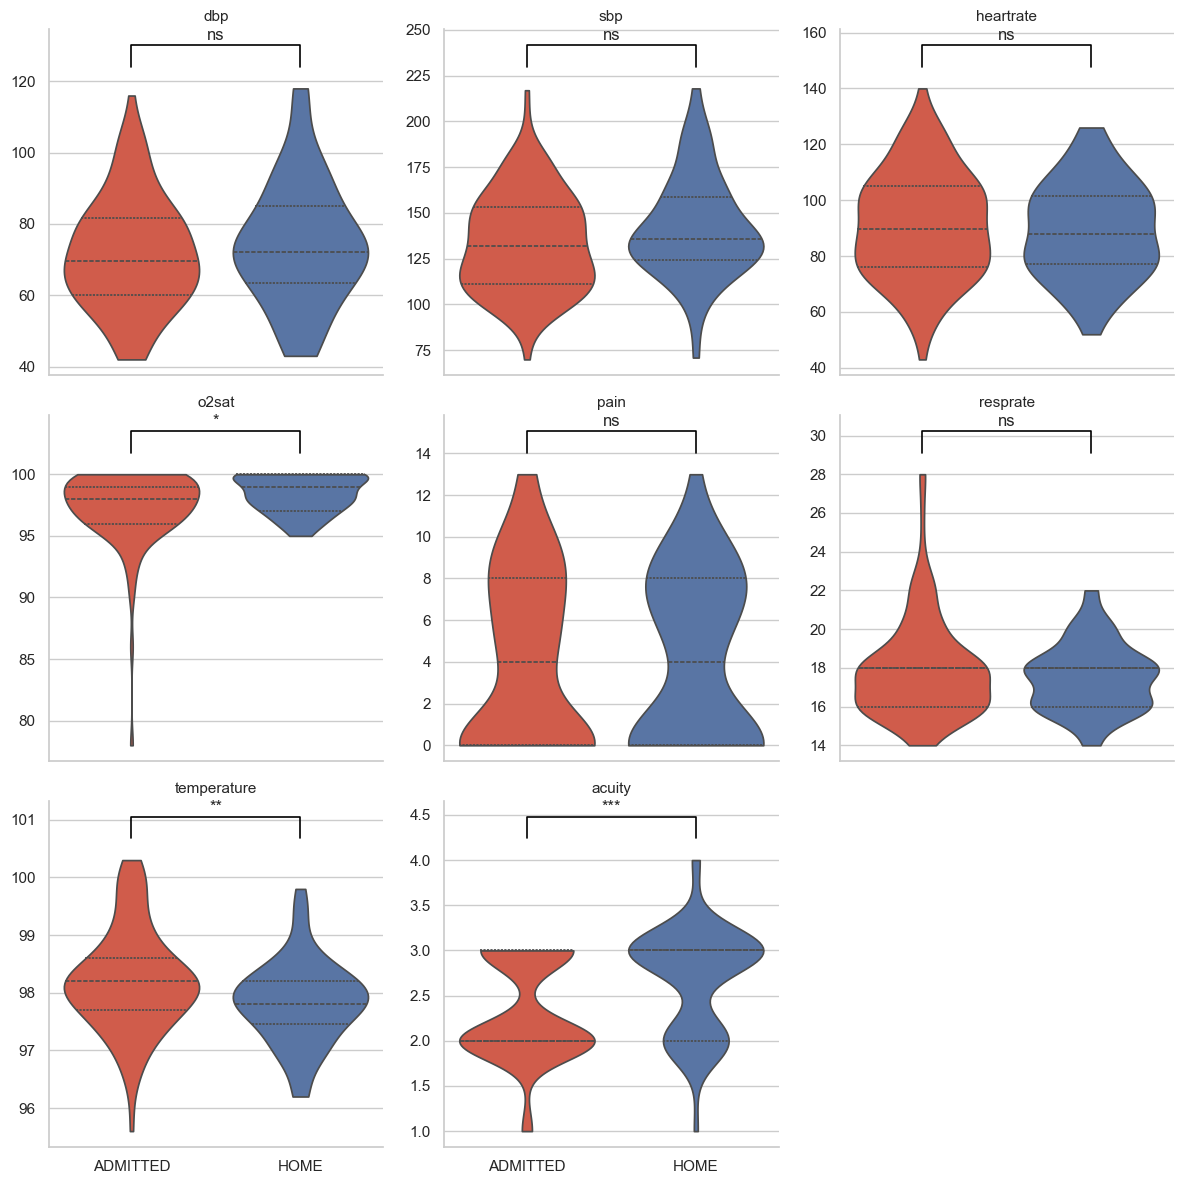

acuity         0.000340
temperature    0.005206
o2sat          0.023309
sbp            0.062195
dbp            0.316014
heartrate      0.530192
resprate       0.776995
pain           0.881694
Name: p_value, dtype: float64

In [119]:
n_cols = 3
n_rows = int(np.ceil(len(feature_cols) / n_cols))

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 4 * n_rows),
    sharex=True,
)

axes = axes.flatten()
p_results = {}

for ax, col in zip(axes, feature_cols):
    p = violin_with_pvalue(ax, df_model, x="disposition", y=col)
    p_results[col] = p

for ax in axes[len(feature_cols):]:
    ax.axis("off")

plt.tight_layout()
savefig("EDA_violin")
plt.show()

p_results = pd.Series(p_results, name="p_value").sort_values()
p_results


### 2.5 Correlation heatmap of predictors

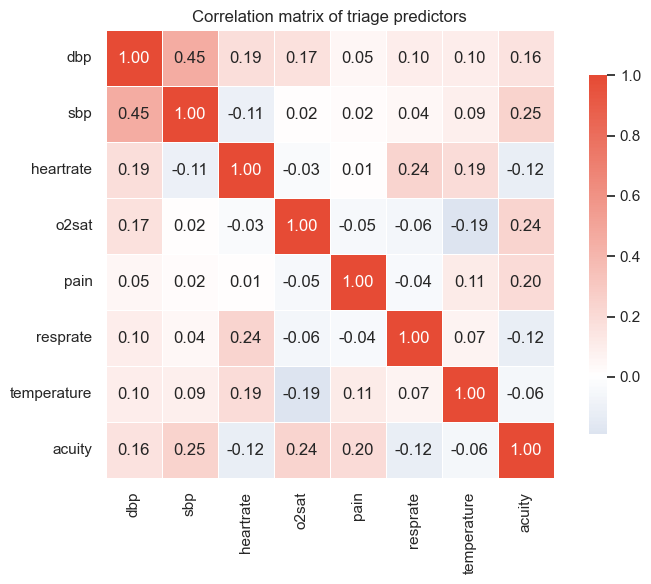

In [120]:
corr_cmap = LinearSegmentedColormap.from_list(
    "blue_orange",
    ["#4C72B0", "white", "#E64B35"]
)

plt.figure(figsize=(8, 6))
corr = df_model[feature_cols].corr()

sns.heatmap(
    corr,
    cmap=corr_cmap,
    annot=True,
    fmt=".2f",
    square=True,
    center=0,        
    linewidths=0.5,  
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation matrix of triage predictors")
plt.tight_layout()
savefig("EDA_corr")
plt.show()

## 3. Model Training & Performance

### 3.1 Feature matrix, target, CV setup

In [72]:
df_model.head()

,disposition,dbp,sbp,heartrate,o2sat,pain,resprate,temperature,acuity,y
0,ADMITTED,65.0,133.0,74.0,96.0,3.0,20.0,97.7,2.0,1
1,HOME,75.0,142.0,74.0,100.0,0.0,18.0,96.2,2.0,0
2,ADMITTED,56.0,100.0,118.0,96.0,0.0,18.0,97.5,2.0,1
3,ADMITTED,48.0,98.0,72.0,90.0,13.0,18.0,98.8,2.0,1
4,HOME,90.0,131.0,89.0,96.0,10.0,18.0,98.1,3.0,0


In [75]:
feature_cols = [
    "dbp", "sbp", "heartrate", "o2sat",
    "pain", "resprate", "temperature", "acuity"
]

X = df_model[feature_cols]
y = df_model["y"]

print("X shape:", X.shape)
print(y.value_counts())

X shape: (173, 8)
y
1    118
0     55
Name: count, dtype: int64


In [76]:
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=42
)
# 5-fold cv, repeating 10 times: 5 * 10 = 50
# mean (Std) of AUROC

In [79]:
def evaluate_model_cv_detailed(model, X, y, cv, threshold=0.5):
    aucs = []
    TP = FP = TN = FN = 0
    
    for train_idx, test_idx in cv.split(X, y):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]

        y_pred = (y_prob >= threshold).astype(int)

        aucs.append(roc_auc_score(y_test, y_prob))
 
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()

        TN += tn
        FP += fp
        FN += fn
        TP += tp

    total = TP + TN + FP + FN
    def safe_div(a, b):
        return a / b if b != 0 else np.nan
 
    accuracy    = safe_div(TP + TN, total)
    sensitivity = safe_div(TP, TP + FN)
    specificity = safe_div(TN, TN + FP)
    prec_pos    = safe_div(TP, TP + FP)
    prec_neg    = safe_div(TN, TN + FN)

    f1_pos = safe_div(2 * prec_pos * sensitivity, prec_pos + sensitivity)
    f1_neg = safe_div(2 * prec_neg * specificity, prec_neg + specificity)
    macro_f1 = np.nanmean([f1_pos, f1_neg])

    return {
        "AUROC_mean": np.mean(aucs),
        "AUROC_std": np.std(aucs),
        "Accuracy": accuracy,
        "Sensitivity (recall_1)": sensitivity,
        "Specificity (recall_0)": specificity,
        "Precision_1 (PPV)": prec_pos,
        "Precision_0 (NPV_like)": prec_neg,
        "F1_1": f1_pos,
        "F1_0": f1_neg,
        "Macro_F1": macro_f1,
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
    }


### 3.2 Logistic regression

In [101]:
logit_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs",
    )),
])

param_grid_logit = {
    "clf__C": [0.1, 0.2, 0.5], # Penalty strength = 1/C
}

grid_logit = GridSearchCV(
    logit_pipe,
    param_grid=param_grid_logit,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
)

grid_logit.fit(X, y)
best_logit = grid_logit.best_estimator_

print("Best Logistic params:", grid_logit.best_params_)


Best Logistic params: {'clf__C': 0.2}


### 3.3 Random forest

In [84]:
param_dist_rf = {
    "n_estimators": [100, 200, 500],
    "max_depth": [2, 3, 4], 
    "min_samples_leaf": [3, 5, 8],
    "max_features": [0.4, 0.5, 0.7],
}

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
)

rand_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
)

rand_rf.fit(X, y)
best_rf = rand_rf.best_estimator_

print("Best RF params:", rand_rf.best_params_)


Best RF params: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 0.7, 'max_depth': 2}


### 3.4 XGBoost

A shallow but stable ensemble with limited tree depth and moderate feature sampling.

In [91]:
pos_ratio = (y == 0).sum() / (y == 1).sum()

param_dist_xgb = {
    "n_estimators": [150, 300, 500],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "min_child_weight": [1, 5, 10],
}

xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=pos_ratio,
    use_label_encoder=False,
)

rand_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
)

rand_xgb.fit(X, y)
best_xgb = rand_xgb.best_estimator_

print("Best XGB params:", rand_xgb.best_params_)


Best XGB params: {'subsample': 0.7, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:19:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### 3.5 Cross-validated performance summary

In [102]:
logit_detail = evaluate_model_cv_detailed(best_logit, X, y, cv)
rf_detail    = evaluate_model_cv_detailed(best_rf,    X, y, cv)
xgb_detail   = evaluate_model_cv_detailed(best_xgb,   X, y, cv)

detail_df = pd.DataFrame(
    [logit_detail, rf_detail, xgb_detail],
    index=["Logistic (tuned)", "RandomForest (tuned)", "XGBoost (tuned)"],
)

detail_df


C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:02:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:02:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:02:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:02:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, ite

,AUROC_mean,AUROC_std,Accuracy,Sensitivity (recall_1),Specificity (recall_0),Precision_1 (PPV),Precision_0 (NPV_like),F1_1,F1_0,Macro_F1,TP,FP,TN,FN
Logistic (tuned),0.683149,0.085875,0.639306,0.629661,0.660000,0.798925,0.453750,0.704265,0.537778,0.621022,743,187,363,437
RandomForest (tuned),0.673557,0.094690,0.641618,0.667797,0.585455,0.775591,0.450980,0.717668,0.509494,0.613581,788,228,322,392
XGBoost (tuned),0.671864,0.084618,0.665896,0.733051,0.521818,0.766844,0.476744,0.749567,0.498264,0.623915,865,263,287,315


## 4. Model Evaluation & Feature Importance Analysis

### 4.1 Out-of-fold probabilities for visualization

In [103]:
cv_vis = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_vis = {
    "Logistic": best_logit,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
}

oof_probs = {}

for name, model in models_vis.items():
    prob = cross_val_predict(
        model,
        X, y,
        cv=cv_vis,
        method="predict_proba",
    )[:, 1]
    oof_probs[name] = prob

for name, prob in oof_probs.items():
    print(name, "prob shape:", prob.shape, "min/max:", prob.min(), prob.max())


C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:02:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:02:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:02:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:02:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, ite

Logistic prob shape: (173,) min/max: 0.1448918523576175 0.9989115333049488
Random Forest prob shape: (173,) min/max: 0.29421123366090135 0.9191974251852479
XGBoost prob shape: (173,) min/max: 0.07421202 0.9682664


C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:02:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### 4.2 ROC curves

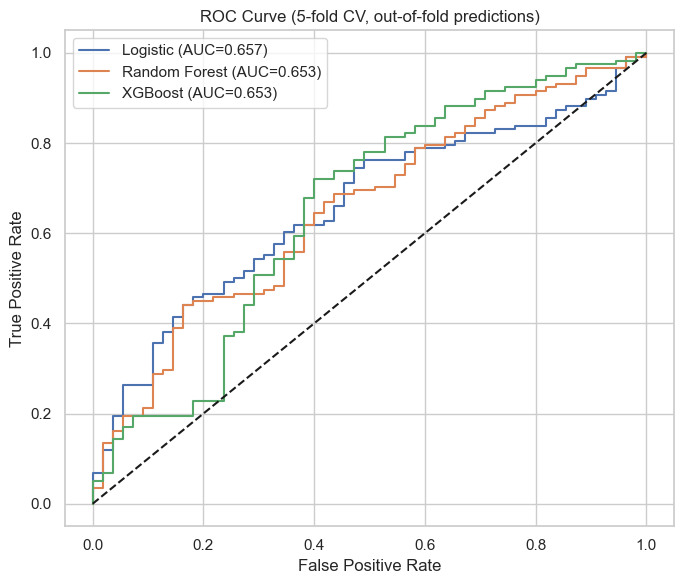

In [121]:
plt.figure(figsize=(7, 6))

for name, prob in oof_probs.items():
    fpr, tpr, _ = roc_curve(y, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (5-fold CV, out-of-fold predictions)")
plt.legend()
plt.grid(True)
plt.tight_layout()
savefig("ROCAUC")
plt.show()


### 4.3 Precision–Recall curves


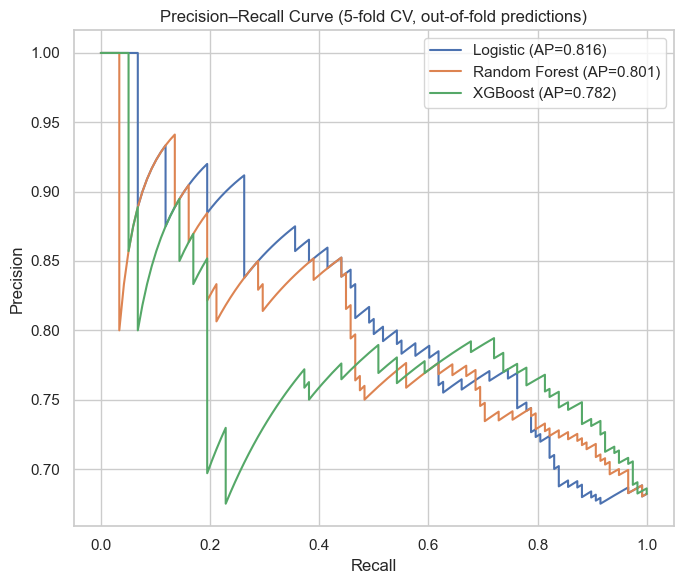

In [122]:
plt.figure(figsize=(7, 6))

for name, prob in oof_probs.items():
    precision, recall, _ = precision_recall_curve(y, prob)
    ap = average_precision_score(y, prob)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (5-fold CV, out-of-fold predictions)")
plt.legend()
plt.grid(True)
plt.tight_layout()
savefig("Precision_recall")
plt.show()


### 4.4 Calibration curves

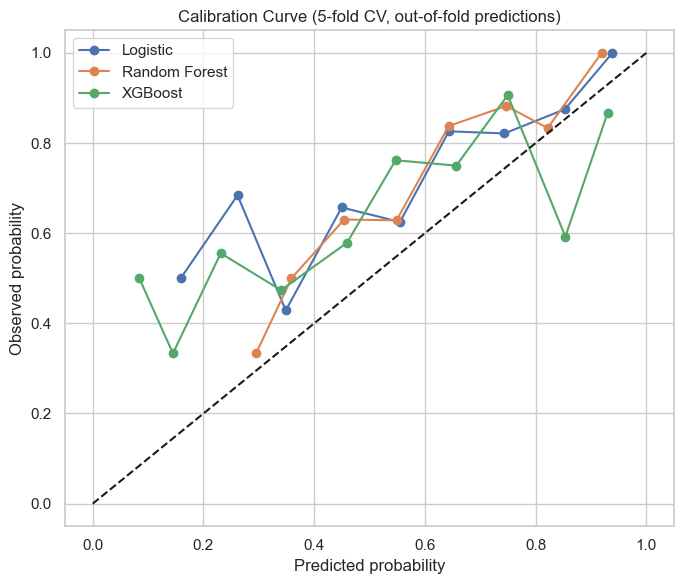

In [123]:
plt.figure(figsize=(7, 6))

for name, prob in oof_probs.items():
    prob_true, prob_pred = calibration_curve(y, prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker="o", label=name)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed probability")
plt.title("Calibration Curve (5-fold CV, out-of-fold predictions)")
plt.legend()
plt.grid(True)
plt.tight_layout()
savefig("Calibration_curve")
plt.show()


### 4.5 Decision curve analysis

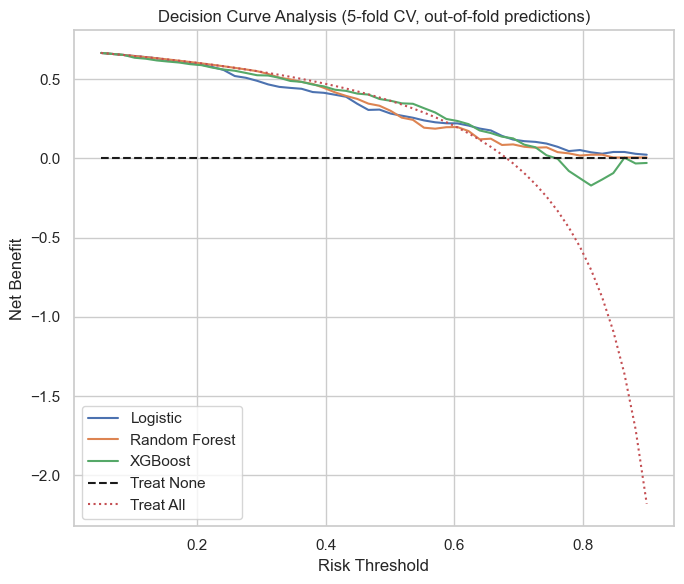

In [124]:
def decision_curve_from_probs(y_true, y_prob, thresholds=np.linspace(0.05, 0.9, 50)):
    N = len(y_true)
    nets = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        net = (tp / N) - (fp / N) * (t / (1 - t))
        nets.append(net)
    return thresholds, np.array(nets)

plt.figure(figsize=(7, 6))

for name, prob in oof_probs.items():
    th, net = decision_curve_from_probs(y, prob)
    plt.plot(th, net, label=name)

p = y.mean()
net_all = p - (1 - p) * (th / (1 - th))
plt.plot(th, np.zeros_like(th), "k--", label="Treat None")
plt.plot(th, net_all, "r:", label="Treat All")

plt.xlabel("Risk Threshold")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (5-fold CV, out-of-fold predictions)")
plt.legend()
plt.grid(True)
plt.tight_layout()
savefig("DCA")
plt.show()


### 4.6 Logistic ORs

In [114]:
X_or = pd.DataFrame(X, columns=feature_cols)
X_or = sm.add_constant(X_or)

logit_sm = sm.Logit(y, X_or)
result = logit_sm.fit(disp=False)

summary = result.summary2().tables[1]

summary["OR"] = np.exp(summary["Coef."])
summary["CI_lower"] = np.exp(summary["Coef."] - 1.96 * summary["Std.Err."])
summary["CI_upper"] = np.exp(summary["Coef."] + 1.96 * summary["Std.Err."])

or_table = summary[["OR", "CI_lower", "CI_upper", "P>|z|"]]
or_table = or_table.rename(columns={"P>|z|": "p_value"})
or_table = or_table.drop("const")

or_table


,OR,CI_lower,CI_upper,p_value
dbp,1.001849,0.977369,1.026941,0.883659
sbp,0.988432,0.973856,1.003225,0.124742
heartrate,0.994974,0.974373,1.016010,0.636900
o2sat,0.821673,0.665957,1.013799,0.066927
pain,1.024244,0.937592,1.118904,0.595308
resprate,1.078277,0.907944,1.280565,0.390277
temperature,1.666048,1.063697,2.609499,0.025765
acuity,0.393886,0.200413,0.774132,0.006879


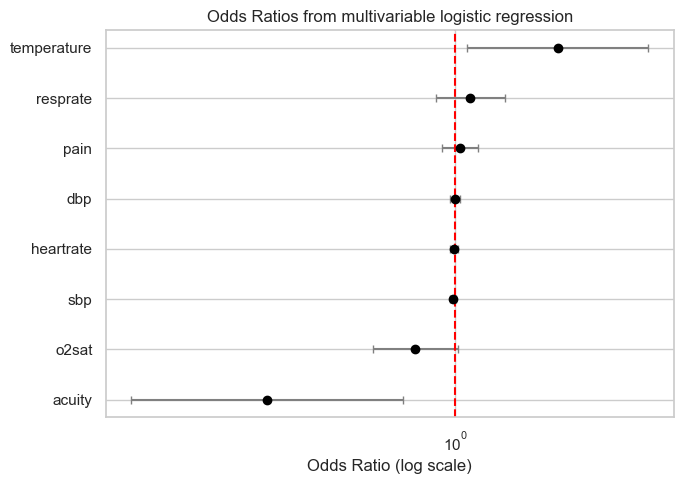

In [125]:
df_plot = or_table.copy()
df_plot = df_plot.sort_values("OR")

plt.figure(figsize=(7, 5))
plt.errorbar(
    df_plot["OR"],
    df_plot.index,
    xerr=[
        df_plot["OR"] - df_plot["CI_lower"],
        df_plot["CI_upper"] - df_plot["OR"],
    ],
    fmt="o",
    color="black",
    ecolor="gray",
    capsize=3,
)
plt.axvline(x=1, linestyle="--", color="red")
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.title("Odds Ratios from multivariable logistic regression")
plt.grid(True, axis="x")
plt.tight_layout()
savefig("OR")
plt.show()


### 4.7 SHAP for XGBoost

C:\Users\May\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [03:04:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


shap_values shape: (173, 8)
X shape: (173, 8)


C:\Users\May\AppData\Local\Temp\ipykernel_22032\577709348.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


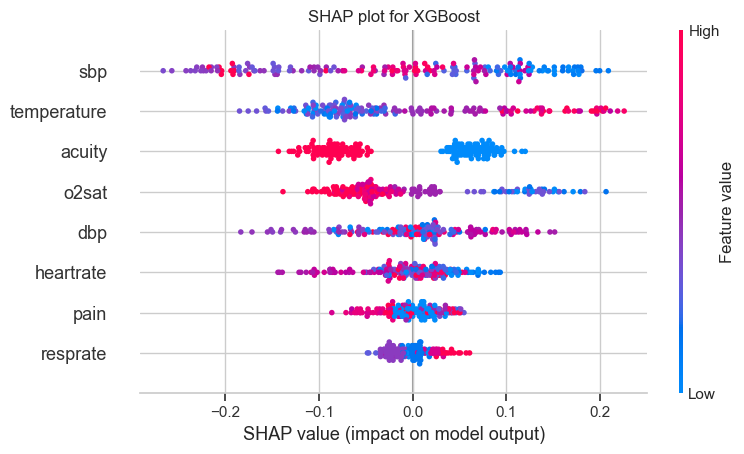

C:\Users\May\AppData\Local\Temp\ipykernel_22032\577709348.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


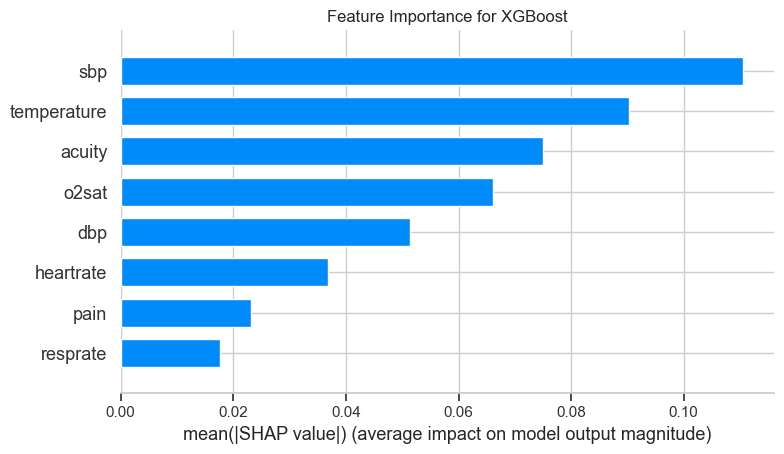

<Figure size 600x400 with 0 Axes>

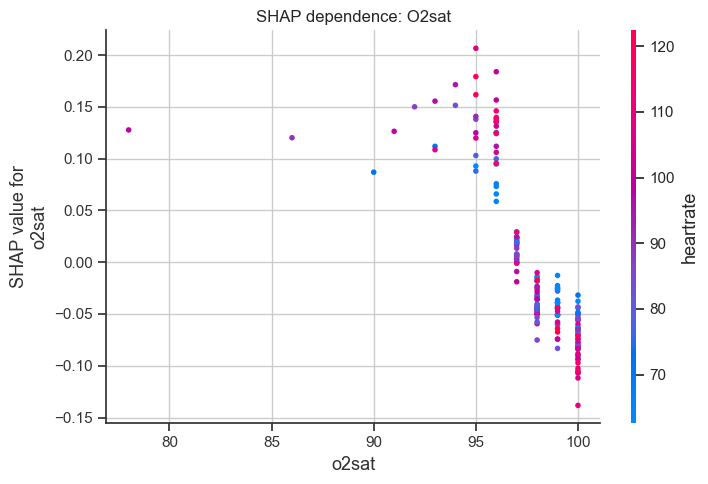

<Figure size 600x400 with 0 Axes>

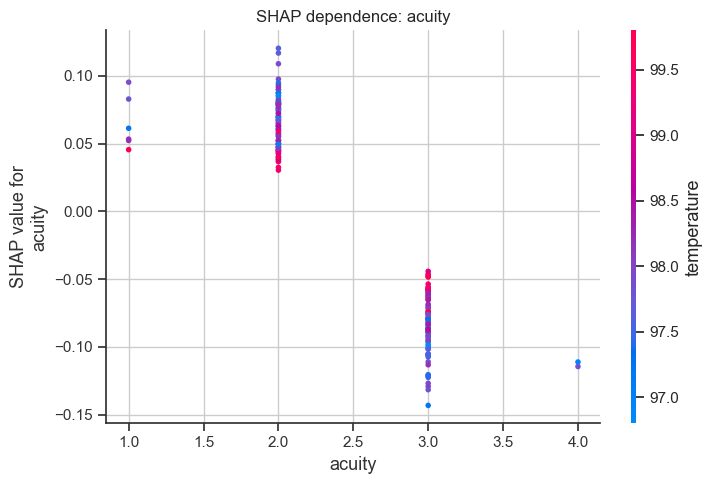

<Figure size 600x400 with 0 Axes>

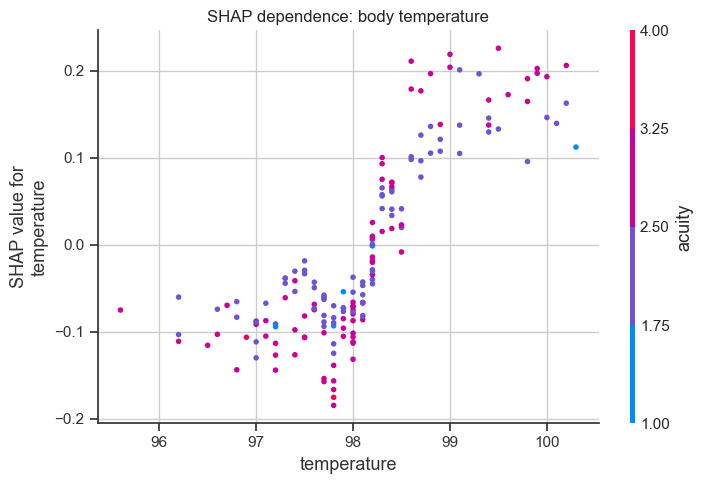

In [126]:
xgb_final = best_xgb.fit(X, y)

def model_pred_proba1(data):
    return xgb_final.predict_proba(data)[:, 1]

explainer = shap.Explainer(model_pred_proba1, X)
shap_exp = explainer(X)
shap_values = shap_exp.values

print("shap_values shape:", shap_values.shape)
print("X shape:", X.shape)

plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X,
    plot_type="dot",
    show=False,
)
plt.title("SHAP plot for XGBoost")
plt.tight_layout()
savefig("SHAP")
plt.show()

plt.figure(figsize=(6, 4))
shap.summary_plot(
    shap_values,
    X,
    plot_type="bar",
    show=False,
)
plt.title("Feature Importance for XGBoost")
savefig("Feature_Importance")
plt.tight_layout()

plt.show()

plt.figure(figsize=(6, 4))
shap.dependence_plot("o2sat", shap_values, X, show=False)
plt.title("SHAP dependence: O2sat")
plt.tight_layout()
savefig("SHAP_de_O2sat")
plt.show()

plt.figure(figsize=(6, 4))
shap.dependence_plot("acuity", shap_values, X, show=False)
plt.title("SHAP dependence: acuity")
plt.tight_layout()
savefig("SHAP_de_acuity")
plt.show()

plt.figure(figsize=(6, 4))
shap.dependence_plot("temperature", shap_values, X, show=False)
plt.title("SHAP dependence: body temperature")
plt.tight_layout()
savefig("SHAP_de_temp")
plt.show()
